In [15]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
import vqe_functions as vqe
import qcnn_functions as qcnn


In [16]:
N = 4
J = 1
l_steps = 10
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.03
epochs = 250
shift_invariance = 0

In [17]:
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [18]:
@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn.qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)


***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 500 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/4 [00:00<?, ?it/s]

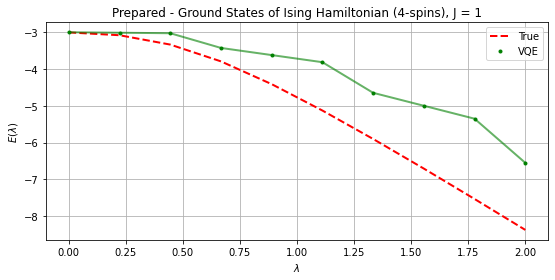

  0%|          | 0/500 [00:00<?, ?it/s]

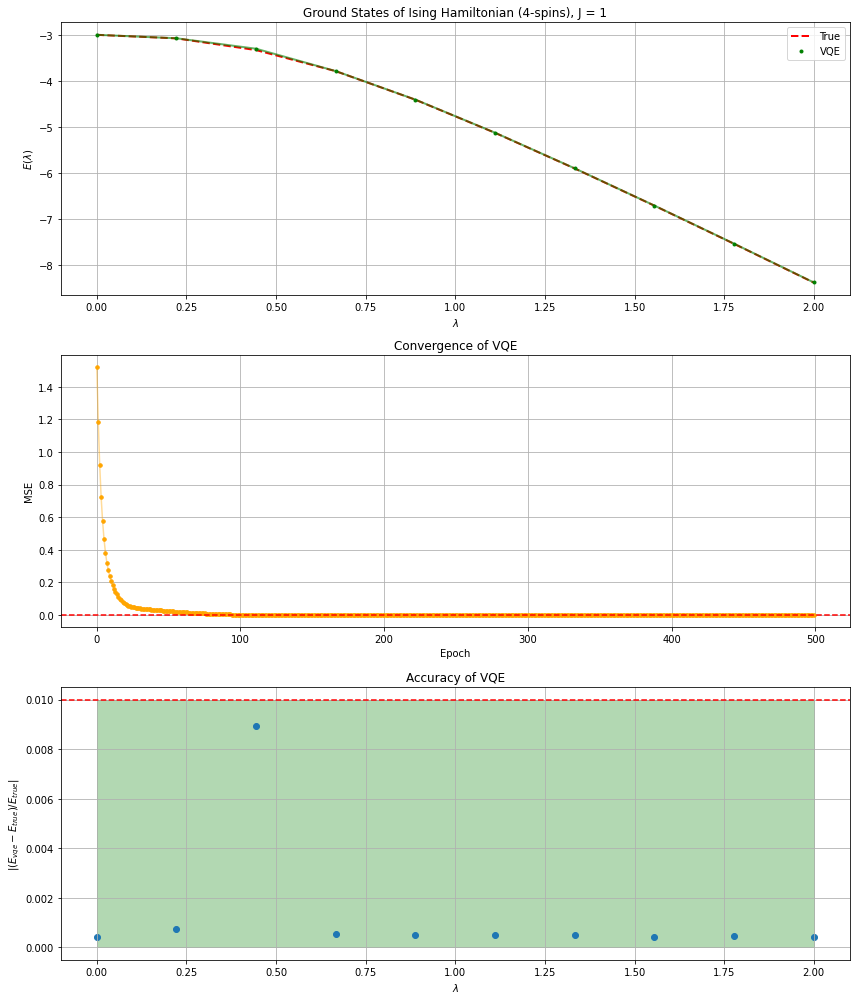

In [19]:
vqe_e, errs, thetas, ys = vqe.mptrain(0.03, 500, N, J, l_steps, vqe_cost_fn_mixed, optimizer = 'Adam',
                                      shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                      circuit = True, plots = True, prepare_states = True, preplots = True,
                                      prep_step_size = 0.05, cutoff_value = .0005)

In [23]:
def optuna_find_hparameters(ntrials = 20, nepochs = 10):
    '''
    Function for Optuna hyperparameter tuning
    '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    def optuna_train(trial):
        '''
        Main function for optuna.
        '''
        epochs = nepochs
        cfg = {
          'step_size': trial.suggest_loguniform('step_size',1e-4,1e0),
          'random_shift': trial.suggest_loguniform('random_shift',1e-8,1e1)
        }
        
        loss_history, accuracy_history, params = qcnn.train(nepochs, cfg['step_size'], cfg['random_shift'], 0, N, 0, 0, 0, 0,
                                                    qcnn_circuit, thetas, ys, plot = True)

        return loss_history[-1]
    
    study.optimize(optuna_train, n_trials=ntrials)
    
    return study

In [ ]:
study = optuna_find_hparameters(ntrials = 100, nepochs = 250)

[I 2022-06-16 10:15:19,896] A new study created in memory with name: no-name-e3896844-387d-47a0-a9e6-ef66d0c1ed20


***Parameters:***

a factor   = 0.00023196745955945453 ('a' coefficient of the optimizer)
r_shift    = 4.049036128758509e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:16:06,794] Trial 0 finished with value: 7.363473547852278 and parameters: {'step_size': 0.00023196745955945453, 'random_shift': 4.049036128758509e-05}. Best is trial 0 with value: 7.363473547852278.


***Parameters:***

a factor   = 0.0007704157572597508 ('a' coefficient of the optimizer)
r_shift    = 0.12485172603658319 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:16:53,152] Trial 1 finished with value: 7.450729977835765 and parameters: {'step_size': 0.0007704157572597508, 'random_shift': 0.12485172603658319}. Best is trial 0 with value: 7.363473547852278.


***Parameters:***

a factor   = 0.0008299418481178197 ('a' coefficient of the optimizer)
r_shift    = 1.830565059049433e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:17:39,770] Trial 2 finished with value: 7.226461163925375 and parameters: {'step_size': 0.0008299418481178197, 'random_shift': 1.830565059049433e-06}. Best is trial 2 with value: 7.226461163925375.


***Parameters:***

a factor   = 0.0008050280193078177 ('a' coefficient of the optimizer)
r_shift    = 1.3327369234945012e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:18:25,649] Trial 3 finished with value: 7.17927231925202 and parameters: {'step_size': 0.0008050280193078177, 'random_shift': 1.3327369234945012e-05}. Best is trial 3 with value: 7.17927231925202.


***Parameters:***

a factor   = 0.18800681810392947 ('a' coefficient of the optimizer)
r_shift    = 1.8546081794188256 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:19:12,308] Trial 4 finished with value: 5.844752050710826 and parameters: {'step_size': 0.18800681810392947, 'random_shift': 1.8546081794188256}. Best is trial 4 with value: 5.844752050710826.


***Parameters:***

a factor   = 0.048063349371286125 ('a' coefficient of the optimizer)
r_shift    = 0.3930503366903516 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:19:58,297] Trial 5 finished with value: 4.492076233696418 and parameters: {'step_size': 0.048063349371286125, 'random_shift': 0.3930503366903516}. Best is trial 5 with value: 4.492076233696418.


***Parameters:***

a factor   = 0.00014902310936257593 ('a' coefficient of the optimizer)
r_shift    = 6.83980969462322 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:20:45,609] Trial 6 finished with value: 7.6537505099142304 and parameters: {'step_size': 0.00014902310936257593, 'random_shift': 6.83980969462322}. Best is trial 5 with value: 4.492076233696418.


***Parameters:***

a factor   = 0.0016648687627511046 ('a' coefficient of the optimizer)
r_shift    = 0.003566312552809482 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:21:31,502] Trial 7 finished with value: 8.456560656433355 and parameters: {'step_size': 0.0016648687627511046, 'random_shift': 0.003566312552809482}. Best is trial 5 with value: 4.492076233696418.


***Parameters:***

a factor   = 0.022386080850290157 ('a' coefficient of the optimizer)
r_shift    = 0.09450600282404814 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:22:16,923] Trial 8 finished with value: 5.120610896308062 and parameters: {'step_size': 0.022386080850290157, 'random_shift': 0.09450600282404814}. Best is trial 5 with value: 4.492076233696418.


***Parameters:***

a factor   = 0.9823320922570676 ('a' coefficient of the optimizer)
r_shift    = 0.002410864198864535 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:23:02,254] Trial 9 finished with value: 3.078592139333599 and parameters: {'step_size': 0.9823320922570676, 'random_shift': 0.002410864198864535}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.9622941853783076 ('a' coefficient of the optimizer)
r_shift    = 2.4155905150038586e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/saverio/Desktop/CERN/code/phase-estimation/qcnn_functions.py:284: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))
[I 2022-06-16 10:23:47,452] Trial 10 finished with value: 3.2860953443248535 and parameters: {'step_size': 0.9622941853783076, 'random_shift': 2.4155905150038586e-08}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.9260328866740692 ('a' coefficient of the optimizer)
r_shift    = 1.433995848503778e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:24:32,671] Trial 11 finished with value: 3.234815627111922 and parameters: {'step_size': 0.9260328866740692, 'random_shift': 1.433995848503778e-07}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.8708994529718244 ('a' coefficient of the optimizer)
r_shift    = 1.0575036220406503e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:25:17,928] Trial 12 finished with value: 3.300324207501977 and parameters: {'step_size': 0.8708994529718244, 'random_shift': 1.0575036220406503e-08}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.17454490545618548 ('a' coefficient of the optimizer)
r_shift    = 0.0006566204713636965 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:26:05,421] Trial 13 finished with value: 3.2071669606076174 and parameters: {'step_size': 0.17454490545618548, 'random_shift': 0.0006566204713636965}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.12956089650012692 ('a' coefficient of the optimizer)
r_shift    = 0.0017568455630042256 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:26:52,945] Trial 14 finished with value: 4.609069182917255 and parameters: {'step_size': 0.12956089650012692, 'random_shift': 0.0017568455630042256}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.19445505952635211 ('a' coefficient of the optimizer)
r_shift    = 0.006276108513811808 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:27:40,031] Trial 15 finished with value: 3.4470506941378267 and parameters: {'step_size': 0.19445505952635211, 'random_shift': 0.006276108513811808}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.008764192807480546 ('a' coefficient of the optimizer)
r_shift    = 0.0003057862849831965 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:28:25,762] Trial 16 finished with value: 4.702073891061537 and parameters: {'step_size': 0.008764192807480546, 'random_shift': 0.0003057862849831965}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.34840455274695226 ('a' coefficient of the optimizer)
r_shift    = 0.00022227930864595724 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:29:11,227] Trial 17 finished with value: 3.2945831995061976 and parameters: {'step_size': 0.34840455274695226, 'random_shift': 0.00022227930864595724}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.045585376548879716 ('a' coefficient of the optimizer)
r_shift    = 0.014238367020593232 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:29:56,726] Trial 18 finished with value: 4.341925402481484 and parameters: {'step_size': 0.045585376548879716, 'random_shift': 0.014238367020593232}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.0035793447700302574 ('a' coefficient of the optimizer)
r_shift    = 3.816865552345263e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:30:42,356] Trial 19 finished with value: 5.134980736543055 and parameters: {'step_size': 0.0035793447700302574, 'random_shift': 3.816865552345263e-06}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.07386537070157657 ('a' coefficient of the optimizer)
r_shift    = 7.916328469965647e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:31:28,003] Trial 20 finished with value: 3.7944974624368433 and parameters: {'step_size': 0.07386537070157657, 'random_shift': 7.916328469965647e-05}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.45667852312164076 ('a' coefficient of the optimizer)
r_shift    = 1.1976018472661174e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:32:14,035] Trial 21 finished with value: 3.1965472446152994 and parameters: {'step_size': 0.45667852312164076, 'random_shift': 1.1976018472661174e-07}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.3589056402820833 ('a' coefficient of the optimizer)
r_shift    = 0.0010758354351394792 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:33:00,133] Trial 22 finished with value: 3.256594026425139 and parameters: {'step_size': 0.3589056402820833, 'random_shift': 0.0010758354351394792}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.49448776088155816 ('a' coefficient of the optimizer)
r_shift    = 2.682571256283245e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:33:45,082] Trial 23 finished with value: 3.304283695820041 and parameters: {'step_size': 0.49448776088155816, 'random_shift': 2.682571256283245e-07}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.10843460599029175 ('a' coefficient of the optimizer)
r_shift    = 0.02345992321476572 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:34:30,098] Trial 24 finished with value: 3.464443928980403 and parameters: {'step_size': 0.10843460599029175, 'random_shift': 0.02345992321476572}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.019619533185286607 ('a' coefficient of the optimizer)
r_shift    = 1.5584017785515772e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:35:15,098] Trial 25 finished with value: 5.250104836702106 and parameters: {'step_size': 0.019619533185286607, 'random_shift': 1.5584017785515772e-05}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.378610504072532 ('a' coefficient of the optimizer)
r_shift    = 0.0009141395026128216 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:36:00,945] Trial 26 finished with value: 3.3541481097090107 and parameters: {'step_size': 0.378610504072532, 'random_shift': 0.0009141395026128216}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.2386396791324023 ('a' coefficient of the optimizer)
r_shift    = 1.0484374604460068e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:36:46,298] Trial 27 finished with value: 3.6976905424148736 and parameters: {'step_size': 0.2386396791324023, 'random_shift': 1.0484374604460068e-06}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.4792508790317057 ('a' coefficient of the optimizer)
r_shift    = 0.00012850127331847673 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:37:31,835] Trial 28 finished with value: 3.166672764964831 and parameters: {'step_size': 0.4792508790317057, 'random_shift': 0.00012850127331847673}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.46580655324950687 ('a' coefficient of the optimizer)
r_shift    = 4.8819198599689247e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:38:18,737] Trial 29 finished with value: 3.3196155866858064 and parameters: {'step_size': 0.46580655324950687, 'random_shift': 4.8819198599689247e-05}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.09346601333646565 ('a' coefficient of the optimizer)
r_shift    = 6.814179421480535e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:39:06,935] Trial 30 finished with value: 4.249504207369134 and parameters: {'step_size': 0.09346601333646565, 'random_shift': 6.814179421480535e-08}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.6094961726822152 ('a' coefficient of the optimizer)
r_shift    = 0.00013389650975155408 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:39:54,668] Trial 31 finished with value: 3.3273676956355867 and parameters: {'step_size': 0.6094961726822152, 'random_shift': 0.00013389650975155408}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.22985905642145005 ('a' coefficient of the optimizer)
r_shift    = 0.045908308172958164 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:40:41,931] Trial 32 finished with value: 3.3215702226305917 and parameters: {'step_size': 0.22985905642145005, 'random_shift': 0.045908308172958164}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.5666182403829437 ('a' coefficient of the optimizer)
r_shift    = 8.026477615744267e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:41:27,968] Trial 33 finished with value: 3.199886078250315 and parameters: {'step_size': 0.5666182403829437, 'random_shift': 8.026477615744267e-06}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.6065532946758743 ('a' coefficient of the optimizer)
r_shift    = 6.968803386355337e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:42:13,695] Trial 34 finished with value: 3.424302256823501 and parameters: {'step_size': 0.6065532946758743, 'random_shift': 6.968803386355337e-07}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.0509125961542761 ('a' coefficient of the optimizer)
r_shift    = 7.10037688463295e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:43:00,983] Trial 35 finished with value: 4.0508996700669595 and parameters: {'step_size': 0.0509125961542761, 'random_shift': 7.10037688463295e-06}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.3207506565787177 ('a' coefficient of the optimizer)
r_shift    = 1.3600314884197925e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:43:47,851] Trial 36 finished with value: 3.6314924489489213 and parameters: {'step_size': 0.3207506565787177, 'random_shift': 1.3600314884197925e-05}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.6538231512264661 ('a' coefficient of the optimizer)
r_shift    = 3.522215576676216e-05 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:44:34,434] Trial 37 finished with value: 3.2909549610787603 and parameters: {'step_size': 0.6538231512264661, 'random_shift': 3.522215576676216e-05}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.0005390278727102942 ('a' coefficient of the optimizer)
r_shift    = 4.17844888790079e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:45:20,513] Trial 38 finished with value: 8.106100734891845 and parameters: {'step_size': 0.0005390278727102942, 'random_shift': 4.17844888790079e-07}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.14208383973538222 ('a' coefficient of the optimizer)
r_shift    = 1.876279855146046e-06 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:46:06,572] Trial 39 finished with value: 3.464908040101645 and parameters: {'step_size': 0.14208383973538222, 'random_shift': 1.876279855146046e-06}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.00479733891659232 ('a' coefficient of the optimizer)
r_shift    = 0.23118546571078294 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:46:51,467] Trial 40 finished with value: 5.143705454455786 and parameters: {'step_size': 0.00479733891659232, 'random_shift': 0.23118546571078294}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.9722736384494669 ('a' coefficient of the optimizer)
r_shift    = 0.0039071072992653815 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:47:36,421] Trial 41 finished with value: 3.6233340801559457 and parameters: {'step_size': 0.9722736384494669, 'random_shift': 0.0039071072992653815}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.22847630035344485 ('a' coefficient of the optimizer)
r_shift    = 0.0008279971794533708 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:48:21,386] Trial 42 finished with value: 3.1123663151764087 and parameters: {'step_size': 0.22847630035344485, 'random_shift': 0.0008279971794533708}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.2641826877219199 ('a' coefficient of the optimizer)
r_shift    = 0.0005253538059049864 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:49:06,498] Trial 43 finished with value: 3.4324241562213635 and parameters: {'step_size': 0.2641826877219199, 'random_shift': 0.0005253538059049864}. Best is trial 9 with value: 3.078592139333599.


***Parameters:***

a factor   = 0.6059842286103758 ('a' coefficient of the optimizer)
r_shift    = 5.035121114034819e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:49:55,208] Trial 44 finished with value: 3.0781348434865294 and parameters: {'step_size': 0.6059842286103758, 'random_shift': 5.035121114034819e-08}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.03141263234047042 ('a' coefficient of the optimizer)
r_shift    = 5.381771765332563e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:50:43,133] Trial 45 finished with value: 3.9450625284982044 and parameters: {'step_size': 0.03141263234047042, 'random_shift': 5.381771765332563e-08}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.7212535343681512 ('a' coefficient of the optimizer)
r_shift    = 1.2165163187800564e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:51:30,618] Trial 46 finished with value: 3.2916978377529023 and parameters: {'step_size': 0.7212535343681512, 'random_shift': 1.2165163187800564e-08}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.07340464205865516 ('a' coefficient of the optimizer)
r_shift    = 1.5980087234356097 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:52:16,840] Trial 47 finished with value: 7.05109222750884 and parameters: {'step_size': 0.07340464205865516, 'random_shift': 1.5980087234356097}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.1805727128860466 ('a' coefficient of the optimizer)
r_shift    = 1.0506590651920887e-07 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:53:04,163] Trial 48 finished with value: 3.3051410470730174 and parameters: {'step_size': 0.1805727128860466, 'random_shift': 1.0506590651920887e-07}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.43167664466809935 ('a' coefficient of the optimizer)
r_shift    = 0.009095206320611402 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:53:50,756] Trial 49 finished with value: 3.1612841792359037 and parameters: {'step_size': 0.43167664466809935, 'random_shift': 0.009095206320611402}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.30855621558240637 ('a' coefficient of the optimizer)
r_shift    = 0.009252467176834511 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:54:36,322] Trial 50 finished with value: 3.2021668526319123 and parameters: {'step_size': 0.30855621558240637, 'random_shift': 0.009252467176834511}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.3894612013857409 ('a' coefficient of the optimizer)
r_shift    = 0.002356520481348717 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:55:21,640] Trial 51 finished with value: 3.3819214124805566 and parameters: {'step_size': 0.3894612013857409, 'random_shift': 0.002356520481348717}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.9919489388122265 ('a' coefficient of the optimizer)
r_shift    = 0.020669272550821065 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:56:07,149] Trial 52 finished with value: 3.2627982028755738 and parameters: {'step_size': 0.9919489388122265, 'random_shift': 0.020669272550821065}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.4760731488498862 ('a' coefficient of the optimizer)
r_shift    = 0.004137840928738368 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:56:52,911] Trial 53 finished with value: 3.198638417796083 and parameters: {'step_size': 0.4760731488498862, 'random_shift': 0.004137840928738368}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.1632581562839413 ('a' coefficient of the optimizer)
r_shift    = 0.07513675779939247 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2022-06-16 10:57:39,026] Trial 54 finished with value: 3.833064173107022 and parameters: {'step_size': 0.1632581562839413, 'random_shift': 0.07513675779939247}. Best is trial 44 with value: 3.0781348434865294.


***Parameters:***

a factor   = 0.6966787783508827 ('a' coefficient of the optimizer)
r_shift    = 3.874341500253278e-08 (c coefficient of the optimizer)
epochs     = 250 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/250 [00:00<?, ?it/s]